[View in Colaboratory](https://colab.research.google.com/github/nenorden/Transfer-learning-on-Fashion-MNIST/blob/master/FeatureExtractionResNet.ipynb)

# Sanity check that cloud GPU is working
Should print: "/device:GPU:0"

In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


# Import data with Tensorflow

In [3]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

%matplotlib inline
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt

import os

os.chdir('/content/fashion-mnist/')
import utils.mnist_reader as mnist_reader
os.chdir("/")

# train and test data
images_train, labels_train = mnist_reader.load_mnist('content/fashion-mnist/data/fashion', kind='train')
images_test, labels_test = mnist_reader.load_mnist('content/fashion-mnist/data/fashion', kind='t10k')

print(images_train.shape)



fatal: destination path 'fashion-mnist' already exists and is not an empty directory.
(60000, 784)


# Have a look at the data

y = 0 (T-shirt/top)


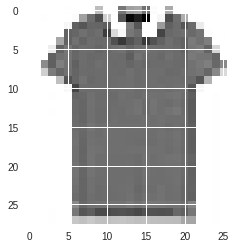

In [4]:
# Map label to clothing for convenience
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# sample train image
rand_i = random.randint(0,images_train.shape[0])
sample = images_train[rand_i].reshape(28,28)
# Get label
sample_label = labels_train[rand_i]

print("y = {label_index} ({label})".format(label_index = sample_label, label = label_dict[sample_label]))

plt.imshow(sample, cmap='Greys')
plt.show()

y = 7 (Sneaker)


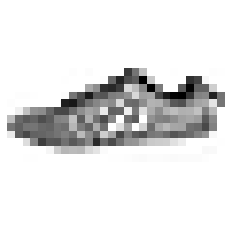

In [78]:

# sample train image
rand_i = random.randint(0,images_train.shape[0])
sample = images_train[rand_i].reshape(28,28)
# Get label
sample_label = labels_train[rand_i]

print("y = {label_index} ({label})".format(label_index = sample_label, label = label_dict[sample_label]))

plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.imshow(sample, cmap='Greys')
plt.show()

# Get pretrained model  Inception-v3
Trained on ImageNet.
OBS - not used for now. See ResNet below instead.



In [0]:
#!git clone https://github.com/tensorflow/models.git
#import os

# Inception-v3 trained on ImageNet
#os.chdir('/content/models/tutorials/image/imagenet')


# run classification program to see that it works. Uses image of panda, so that should be the top scorer, ~ 88 %
#%run classify_image.py

# Get ResNet18 via PyTorch
Library import copied from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py

In [13]:
!git clone https://github.com/torch/torch.github.io.git
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Cloning into 'torch.github.io'...
remote: Counting objects: 1771, done.
remote: Total 1771 (delta 0), reused 0 (delta 0), pack-reused 1771
Receiving objects: 100% (1771/1771), 54.11 MiB | 62.04 MiB/s, done.
Resolving deltas: 100% (894/894), done.
    80% |█████████████████████████▋      | 474.8MB 52.8MB/s eta 0:00:03

    100% |████████████████████████████████| 592.3MB 31.1MB/s 
    100% |████████████████████████████████| 61kB 4.1MB/s 
    100% |████████████████████████████████| 2.0MB 10.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
13.9%

100.0%


ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

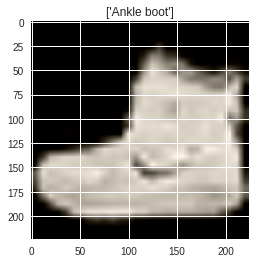

In [14]:
from torch.utils.data import Dataset
from PIL import Image

# Fashion-MNIST help function
class FashionMnist(Dataset):
  def __init__(self, X, y, transform=None):
    self.X = X
    self.y = y
    self.transform = transform
        
  def __len__(self):
    return len(self.X)
    
  def __getitem__(self, idx):
    sample = Image.fromarray(self.X[idx].reshape(28,28))
        
    if self.transform:
      sample = self.transform(sample)
    return sample, self.y[idx]
  
trans = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create a set containing the Fashion-MNIST data
FashionMnist_set = {} 
FashionMnist_set['train'] = FashionMnist(images_train, labels_train, trans)
FashionMnist_set['test'] = FashionMnist(images_test, labels_test, trans)

resnet = models.resnet18(pretrained = True)
modules = list(resnet.children())[:-1]
resnet_ft = nn.Sequential(*modules).cuda()

# Have a look at the model
print(resnet)

BATCH_SIZE = 1 # can take different values

dataloaders = {x: torch.utils.data.DataLoader(FashionMnist_set[x], 
               batch_size=BATCH_SIZE, shuffle=False, num_workers=4) 
               for x in ['train', 'test']}

dataset_sizes = {x: len(FashionMnist_set[x]) for x in ['train', 'test']}

inputs, classes = next(iter(dataloaders['train']))

# Help function to show image
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label_dict[x] for x in classes])


# Use Fashion-MNIST data as input to the pretrained model
Note that it takes some time to iterate over all data.
CPU is used - exceeds Google Collab free GPU

In [15]:
# Features will be saved in this set
features = {}
features['train'] = []
features['test'] = []

# Loop through all training data, store features (given by calling pretrained model). 50,000 images - takes time! 
for i, (images, labels) in enumerate(dataloaders['train']):
  if i%500 == 0:
    print(i)

  images = images.expand(-1, 3, -1,-1)
  images = Variable(images).cuda()
  features['train'].append(resnet_ft(images).data.cpu().numpy().squeeze())

print("Done with training data!")  
    
# Do same for test data. 10,000 images
for i, (images, labels) in enumerate(dataloaders['test']):
  if i%500 == 0:
    print(i)

  images = images.expand(-1, 3, -1,-1)
  images = Variable(images).cuda()
  features['test'].append(resnet_ft(images).data.cpu().numpy().squeeze())
  
print("Done with test data!")  

features['train'] = np.array(features['train'])  
features['test'] = np.array(features['test'])

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
Done with training data!
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
Done with test data!


# Save features

In [0]:
### Save ResNet features
import os
if not os.path.isdir("ResNet_features"):
    os.mkdir("ResNet_features")
    
    
np.save('ResNet_features/' + 'train_fashion-MNIST_resnet.npy', features['train'])
np.save('ResNet_features/' + 'test_fashion-MNIST_resnet.npy', features['test'])
